In [1]:
import time
import torch
import math
import pandas as pd
import numpy as np
import arviz as az
import tqdm
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

from scipy.stats import gaussian_kde
from scipy.linalg import helmert

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath, GeodesicProbPath
from flow_matching.solver import Solver, ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
import math
import torch
from torch.utils.data import Dataset, DataLoader

# visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from sbmfi.inference.arxiv_polytope_plotter import plot_dataframes

from torch.autograd.functional import jacobian

from sbmfi.priors.mog import *
from sbmfi.core.coordinater import *
from sbmfi.core.linalg import LinAlg
from sbmfi.inference.continuous_flows import *
import time


ModuleNotFoundError: No module named 'sbmfi.inference.arxiv_polytope_plotter'

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.set_default_dtype(torch.float)
torch.manual_seed(42)

Using gpu


In [3]:
fcm, v_representation, pol_volume = pickle.load(open('spiro_flux_coordinate_mapper.p', 'rb'))
psm = fcm.sampler

data = az.from_netcdf('mog_polytope_105k_samples.nc')
mog_rounded = az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values.T

mog_target = MixtureOfGaussians(
    means=torch.as_tensor(data.attrs['mog_means'], dtype=torch.float), 
    covariances=torch.as_tensor(data.attrs['mog_covs'], dtype=torch.float),
    weights=torch.as_tensor(data.attrs['mog_weights'], dtype=torch.float),
    log_Z=np.log(data.attrs['mog_Z']),
)
means_df = pd.DataFrame(
    np.hstack([data.attrs['mog_means'], data.attrs['mog_weights'][:, None]]), 
    columns=psm.rounded_id.append(pd.Index(['weights']))
)
mog_Z = data.attrs['mog_Z']
del data

K = psm.dimensionality


In [4]:
# max_ent = map_rounded_2_max_entropy(mog_rounded, v_representation.values, tolerance=1e-10)
# pickle.dump(max_ent, open('max_ent.p', 'wb'))
max_ent = pickle.load(open('max_ent.p', 'rb'))

In [5]:
max_ent = torch.as_tensor(max_ent)

la = LinAlg('torch')
ilrs = map_simplex_2_ilr(max_ent, la, eps=0.0)
on_boundary = torch.isnan(ilrs).any(1) 
ilrs = ilrs[~on_boundary]
U, Sig, V = torch.linalg.svd(ilrs[:5000])
V = V.T[:, :K]
print(f'number of target points on the boundary: {on_boundary.sum()}')

number of target points on the boundary: 38


In [6]:
print(f'eigenvalues from the SVD: {Sig}')

tensor([6.3239e+02, 2.6658e+02, 1.8928e+02, 6.2663e+01, 1.3821e-13, 1.1375e-13,
        9.4583e-14, 5.5620e-14, 4.7848e-14, 3.1849e-14, 2.8181e-14, 2.6175e-14,
        1.8467e-14], dtype=torch.float64)

In [59]:
K = psm.dimensionality
truncated_ilrs = ilrs @ V
reconstructed_ilrs = truncated_ilrs @ V.T
print(f'max reconstruction error: {np.linalg.norm(ilrs - reconstructed_ilrs, 2, -1).max()}')
print(f'fraction clipped values: {(abs(truncated_ilrs) > 20).sum() / np.prod(truncated_ilrs.shape)}')
truncated_ilrs = truncated_ilrs.clip(-20, 20)


max reconstruction error: 2.813483578276347e-05
fraction clipped values: 0.006478535011410713


In [61]:
def train_affine(model, optimizer, losses, target_dataloader):
    n_steps = n_epochs * len(target_dataloader)
    pbar = tqdm(total=n_steps, ncols=120, position=0)
    try:
        for epoch in range(n_epochs):
            for i, target_chunk in enumerate(target_dataloader):
                optimizer.zero_grad() 
                noise_chunk = target_dist.sample((batch_size,))
                t = torch.rand(noise_chunk.shape[0]).to(device) 
                
                # sample probability path
                path_sample = path.sample(t=t, x_0=noise_chunk, x_1=target_chunk[0])
            
                # flow matching l2 loss
                loss = torch.pow(model(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
            
                # # optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                else:
                    raise ValueError(f'loss: {loss}')
        
                loss_ = loss.item()
                losses.append(loss_)
                pbar.update()
                pbar.set_postfix(loss=round(loss_, 4))
    except KeyboardInterrupt:
        pass
    except Exception as e:
        raise e
    finally:
        pbar.close()
        return pbar.last_print_t - pbar.start_t

In [62]:
# training arguments
lr = 1e-3
n_epochs = 50
batch_size = 1024*8
hidden_dim = 512

# velocity field model init
aff_model = MLP(input_dim=K, time_dim=1, hidden_dim=hidden_dim, hidden_layers=7).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optimizer = torch.optim.Adam(aff_model.parameters(), lr=lr) 
scheduler = None

mu = truncated_ilrs.mean(0)
std = truncated_ilrs.std(0)

norm_tilrs = (truncated_ilrs - mu) / std
target_dataset = torch.utils.data.TensorDataset(torch.as_tensor(norm_tilrs, dtype=torch.float, device=device))
target_dataloader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

test_size = 20000

loc = torch.zeros(K, dtype=torch.float, device=device)
cov = torch.as_tensor(np.cov(norm_tilrs.T), dtype=torch.float, device=device)
target_dist = torch.distributions.MultivariateNormal(loc, cov*0.1)

train_time_total = 0.0
losses = []

In [63]:
train_time = train_affine(aff_model, optimizer, losses, target_dataloader)
train_time_total += train_time

torch.save(aff_model.state_dict(), "bary_model.pt")
pickle.dump((losses, train_time_total), open('bary_losses.p', 'wb'))

losses, train_time_total = pickle.load(open('bary_losses.p', 'rb'))
aff_model.load_state_dict(torch.load("bary_model.pt"))

C:\Users\diede\AppData\Local\Temp\ipykernel_14644\991703066.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aff_model.load_state_dict(torch.load("bary_model.pt"))


<All keys matched successfully>

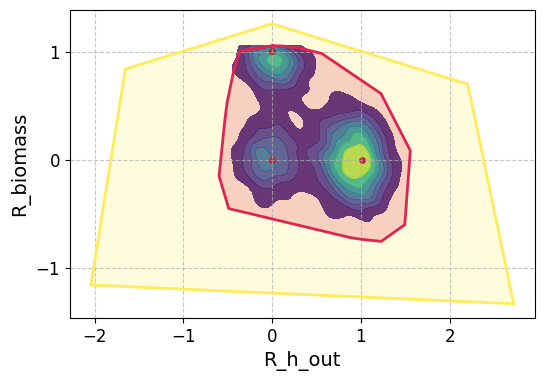

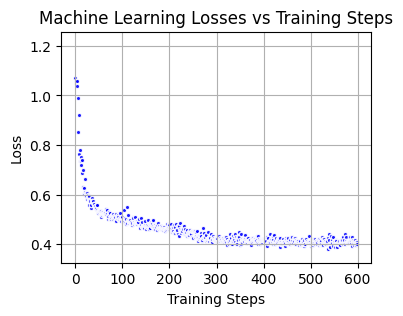

In [64]:
plot_losses_vs_steps(losses)
plt.show()

In [65]:

n_test_samples = 20000
wrapped_vf = WrappedModel(aff_model)
x_init = target_dist.sample((n_test_samples, ))
solver = ODESolver(velocity_model=wrapped_vf)


In [48]:
t_sample_start = time.time()
sol, log_det = sample_and_div(
    ode_solver=solver,
    x_init=x_init,
    step_size=0.05,
    method= "midpoint",
    return_intermediates = False,
    return_div= True,
    exact_divergence=False,
)
t_sample_elapsed = time.time() - t_sample_start

In [67]:
pickle.dump((sol.to(device='cpu'), log_det.to(device='cpu'), t_sample_elapsed), open('bary_flow_sols_log_dets.p', 'wb'))
sol, log_det, t_sample_elapsed = pickle.load(open('bary_flow_sols_log_dets.p', 'rb'))


In [68]:
t_only_sample = time.time()
_ = solver.sample(
    x_init=x_init,
    method='midpoint',
    step_size=0.05,
    return_intermediates=False,
)  # sample from the model
t_only_sample_elapsed = time.time() - t_only_sample

In [69]:


sol = sol.to('cpu')
sol_pilrs = (sol * std) + mu
sol_ilrs = sol_pilrs @ V.T

H = torch.as_tensor(helmert(v_representation.shape[0]), dtype=sol_ilrs.dtype)
vrep = torch.as_tensor(v_representation.values, dtype=sol_ilrs.dtype)

# uncomment the lines below to check the jacobian; should equal tot_J[0]
# def func(sol):
#     result = sol * std + mu
#     result = result @ V.T
#     result = (H.T @ result.T).T
#     result = result.exp()
#     result = result / result.sum(axis=1)
#     result = vrep.T @ result.T
#     return result
# autojac = jacobian(func, sol[[0]])

sol_simplex, J_ilr = map_ilr_2_simplex(sol_ilrs, la, H=H, jacobian=True)
sol_pol = (vrep.T @ sol_simplex.T).T

diag_std = torch.diag_embed(std).to(sol_ilrs.dtype)
tot_J = diag_std @ V.T @ J_ilr.transpose(-1, -2) @ vrep

log_abs_det_J_aitchison = torch.log(abs(torch.det(tot_J)))

In [70]:
sol_filter = torch.isnan(sol_pol).any(1)

log_q = ((target_dist.log_prob(x_init).to('cpu') - log_det.to('cpu')) - log_abs_det_J_aitchison)[0, ~sol_filter]

log_pol_vol = torch.log(torch.as_tensor(pol_volume))
log_p = mog_target.log_prob(sol_pol[~sol_filter])

In [73]:
n_test = x_init.shape[0]
diff = log_p - log_q
diff[diff>0] = 0.0
ws = torch.exp(diff)
KL_Z = ws.mean()
ln_KL = (log_p - log_q).mean() + torch.log(KL_Z)
KL = torch.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()

print(f'ESS: {round(ESS.item() / n_test, 3)}, KL div.: {KL:.3e}, in pol: {0},' \
    f'training time: {train_time_total}, sampling time: {t_sample_elapsed}, only sample time {t_only_sample_elapsed}, points: {sol_filter.sum()}')

ESS: 0.718, KL div.: 4.784e-01, in pol: 0,training time: 213.68421292304993, sampling time: 11.447383642196655, only sample time 1.6938984394073486, points: 0


In [39]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=v_representation,
    samples=pd.DataFrame(sol_pol, columns=fcm.sampler.rounded_id),
    n_sample_cdf=2000,
    points=means_df,
    x_col='R_h_out', 
    y_col='R_biomass',
    x_label='R_h_out', 
    y_label='R_biomass',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
# plt.show()

In [40]:
plt.savefig(
    'bary_flow.svg', transparent=None, dpi='figure', format='svg',
    metadata=None, bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto', backend=None,
)